# Galactic Plane Survey of Rubin Observatory's LSST

This notebook explores the footprint of the Rubin Observatory's Galactic Plane survey.  Full information on the Rubin Observatory's overall process for establishing its survey strategy can be found [on the Observatory's website](https://survey-strategy.lsst.io/index.html), and described in [Bianco et al. (2022)](https://iopscience.iop.org/article/10.3847/1538-4365/ac3e72). 

The footprint for the Rubin Galactic Plane Survey was based on recommendations from [Street et al. 2023](https://iopscience.iop.org/article/10.3847/1538-4365/acd6f4), and then further refined to ensure the footprint was contiguous.  The resulting footprint was published in the [Phase 3 Report from Rubin's Survey Cadence Optimization Committee](https://pstn-056.lsst.io/). 

In [2]:
import healpy as hp
from os import path
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord
from astropy.io import fits
import json
import numpy as np

Load the survey footprint, which is included in the accompanying JSON file.  The HEALpixel coordinate system in use is the default one used by [HEALpy](https://healpy.readthedocs.io/en/latest/index.html), i.e. RING using equatorial coordinates.  

The JSON file contains some metadata about the definition of the footprint, including the NSIDE parameter and the full-sky map of HEALpixels.  

In [6]:
data_file = './rubin_galplane_survey_footprint.json'

# This produces a dictionary of the footprint description
with open(data_file, 'r') as f:
    footprint = json.load(f)

for key, value in footprint.items():
    if key != 'healpix_map':
        print(key + ' = ' + str(value))
    else:
        print(key + ' = Array of HEALpixels with ' + str(len(value)) + ' pixels')

nside = 64
healpix_resolution_deg = 0.8392936452111668
n_healpix = 49152
healpix_map = Array of HEALpixels with 49152 pixels


HEALpy provides tools for visualizing HEALpixel data in various projections.  The Mollweide projection in equatorial coordinates is the one commonly used within the Rubin community.  

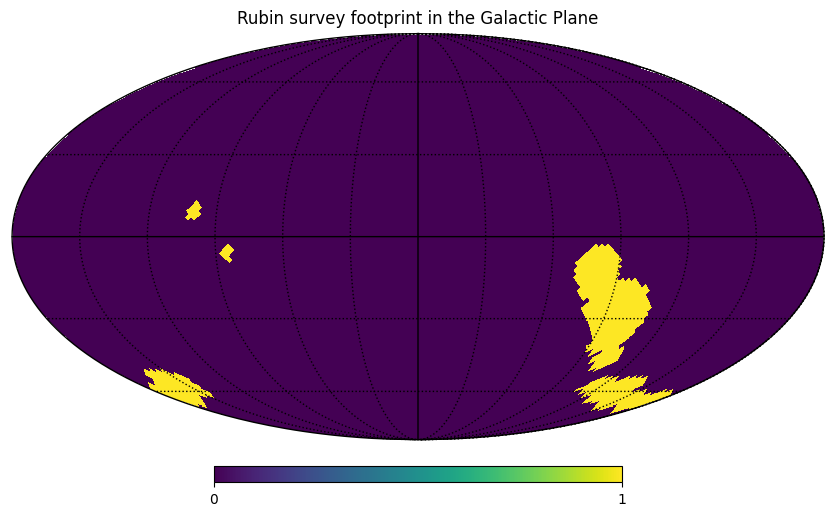

In [7]:
gp_map = np.array(footprint['healpix_map'])

hp.mollview(gp_map, title='Rubin survey footprint in the Galactic Plane')
hp.graticule()

> *Figure 1:* Plot of the Rubin Galactic Plane Survey footprint.

It can also be convienient to rotate this footprint to galactic coordinates, which can be done as follows:

In [8]:
def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    """Rotates healpix map from one system to the other. Returns reordered healpy map.
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2.
    Original code by Xiaolong Li
    """

    # For reasons I don't understand, entering in ['C', 'G'] seems to do the
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.

    # Heavily influenced by stack overflow solution here:
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy

    nside = hp.npix2nside(len(hpmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)

    return rot_map

In [9]:
gp_map_gal = rotateHealpix(gp_map, transf=['G','C'])

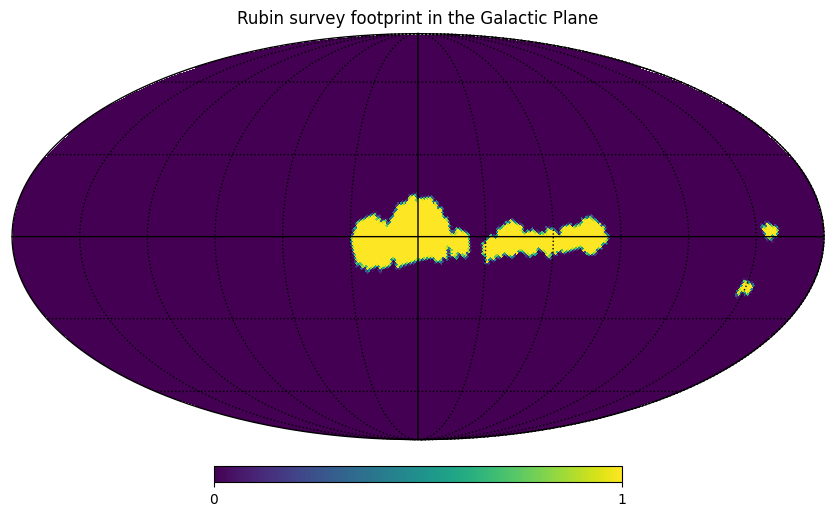

In [10]:
hp.mollview(gp_map_gal, title='Rubin survey footprint in the Galactic Plane')
hp.graticule()

> *Figure 2:* Rubin Galactic Plane Survey footprint in galactic coordinates

Using this footprint, we can estimate the total area covered in the footprint based on the number of HEALpixels included and the area covered by 1 HEALpixels at the map resolution used. 

In [11]:
pix_area = hp.nside2pixarea(footprint['nside'], degrees = True)
print('1 HEALpixel has area ' + str(pix_area) + 'sq.deg.')

n_pix_in_survey = len(np.where(gp_map > 0.0)[0])
print(str(n_pix_in_survey) + ' HEALpix in survey footprint')

survey_area = n_pix_in_survey * pix_area
print('Total area covered by survey footprint = ' + str(survey_area) + 'sq.deg.')

1 HEALpixel has area 0.8392936452111668sq.deg.
1768 HEALpix in survey footprint
Total area covered by survey footprint = 1483.8711647333428sq.deg.
